# <center>NEURAL NETWORKS AND DEEP LEARNING (MDS471)</center>

## <center>CIA ASSIGNMENT COMPONENT: SKIN CANCER DETECTION</center>

#### <center>Name: Aishwarya Shinde R</center>
#### <center>Register Number: 2448008</center>

## 1.	DATASET SELECTION

**Dataset Name:** Melanoma Cancer Image Dataset

**Source:** Kaggle (https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset)

**Description:** This dataset provides a collection of 13,900 high-resolution skin lesion images, primarily intended for the classification of melanoma (a severe form of skin cancer) vs. non-melanoma conditions. Image sizes typically around 64×64 pixels. These images are labelled into two primary classes for binary classification:

* Malignant (cancerous/melanoma)
* Benign (non-cancerous/non-melanoma)


## 2.	JUSTIFICATION OF RELEVANCE

Melanoma is one of the most aggressive and deadly forms of skin cancer. According to the World Health Organization, early detection significantly increases the chances of survival. However, access to dermatologists is limited in many regions. 

**This dataset is highly relevant for the following reasons:**<br> 
**i)	Real-World Healthcare Problem:** Skin cancer diagnosis is a critical medical challenge, and this dataset directly targets the automated classification of melanoma, contributing to global healthcare advancements.<br>
**ii)	High Practical Impact:** Automating skin lesion classification using deep learning models (like CNNs) can assist clinicians in early diagnosis, particularly in resource-limited settings, reducing diagnostic delays.

## 3. OBJECTIVE

Develop and evaluate a **convolutional neural network (CNN) to distinguish melanoma (malignant) from benign skin lesions** using the Melanoma Cancer Image Dataset.

## 4. IMPLEMENTATION

## Load and Pre-process Data

#### Step 1: Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

* The warnings module suppresses all warnings globally for the rest of the session.

In [3]:
# Import Necessary Libraries
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
import random
from collections import Counter

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

* os – File-system operations: building paths, listing folders, making directories.
* matplotlib.pyplot as plt – General plotting: sample images, learning curves, ROC/PR curves.
* seaborn as sns – Nicer statistical visuals, especially the confusion matrix.
* numpy as np – Array math; converting tensors to NumPy for scikit-learn metrics; reshaping, stacking, etc.
*  savgol_filter - smoothens noisy data for more continuous trend preserving the overall shape of the curve. 
* random – Sampling/shuffling to pick random images to visualize). Seed it for reproducibility.
* collections.Counter – Quick class counts (e.g., how many benign vs malignant) to check imbalance.
* sklearn.model_selection.train_test_split – Splits arrays/lists of file paths into train/val/test.
* tensorflow as tf – The deep learning engine you train with.
* tensorflow.keras.Sequential – A simple container to stack layers in order for the CNN.
* Layers (Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten, BatchNormalization)    
    - Conv2D: learns spatial features from images.
    - MaxPooling2D/AveragePooling2D: downsample feature maps (max keeps strongest response; average keeps mean).
    - BatchNormalization: stabilizes/accelerates training by normalizing activations.
    - Dropout: regularization; randomly zeroes units to reduce overfitting.
    - Flatten: flattens 2D feature maps to 1D before dense layers.
    - Dense: fully connected layers; final one outputs the class probability.

* sklearn.metrics (classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score)
    - classification_report: precision/recall/F1 per class + support.
    - confusion_matrix: TP/FP/FN/TN counts.
    - roc_curve/auc: ROC line (TPR vs FPR) and its area.
    - precision_recall_curve/average_precision_score: PR curve and PR-AUC curve.

#### Step 2: Defining Dataset Paths and Image Configuration

In [5]:
# Loading Training Data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/melanoma-cancer-dataset/train",
    image_size=(64, 64),
    label_mode='int',
    batch_size = 32,
    validation_split = 0.25,
    subset = "training",
    seed = 42
)

# Loading Validation Data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/melanoma-cancer-dataset/train",
    image_size=(64, 64),
    label_mode='int',
    batch_size = 32,
    validation_split = 0.25,
    subset = "validation",
    seed = 42
)

# Loading Test Data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/melanoma-cancer-dataset/test",
    image_size=(64, 64),
    label_mode='int',
    batch_size = 32,
    shuffle = False
)

# Print class labels / mapping
class_names = train_ds.class_names
class_to_index = {name: i for i, name in enumerate(class_names)}
print("\nClass names:", class_names)
print("Class Mapping:", class_to_index)

Found 11879 files belonging to 2 classes.
Using 8910 files for training.
Found 11879 files belonging to 2 classes.
Using 2969 files for validation.
Found 2000 files belonging to 2 classes.

Class names: ['Benign', 'Malignant']
Class Mapping: {'Benign': 0, 'Malignant': 1}



* Builds train and validation datasets from the same train/ folder using validation_split=0.25 with a fixed seed=42 for a reproducible 75/25 split.
* Loads test from a separate test/ folder with shuffle=False so predictions line up deterministically.
* Uniform settings: image_size=(64,64), batch_size=32 (controls how many images are processed at once during training or prediction.), label_mode='int' (integer labels 0/1).
* Extracts class mapping from folder names (train_ds.class_names) to interpret metrics.


# Exploratory Data Analysis (EDA)

#### Step 3: Display Class Counts Using Bar Plots

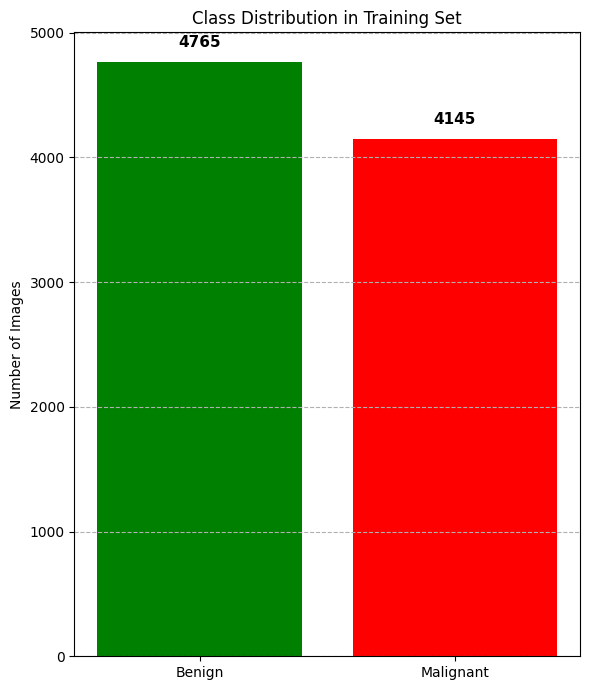

In [6]:
# Count samples per class from the dataset (after split)
counts = np.zeros(len(class_names), dtype=int)
for _, y in train_ds.unbatch():
    counts[int(y.numpy())] += 1

# Consistent colors for known classes
color_map = {"Malignant": "red", "Benign": "green"}
colors = [color_map.get(name, "gray") for name in class_names]

# Bar plot
plt.figure(figsize=(6, 7))
bars = plt.bar(class_names, counts, color=colors)

# Annotate counts above each bar
for bar, c in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2.0,
             bar.get_height() + max(1, 0.02 * max(counts)),
             f"{int(c)}",
             ha="center", va="bottom", fontsize=11, fontweight="bold")

plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.grid(axis="y", linestyle="--")
plt.tight_layout()
plt.show()

#### Step 4: Check for Class Imbalance

In [7]:
idx_benign = class_names.index("Benign")
idx_malignant = class_names.index("Malignant")

per_class = Counter(int(y.numpy()) for _, y in train_ds.unbatch())

benign_count = per_class.get(idx_benign, 0)
malignant_count = per_class.get(idx_malignant, 0)
total = benign_count + malignant_count
if total == 0:
    raise ValueError("train_ds appears empty after unbatch().")

benign_pct = benign_count / total * 100
malignant_pct = malignant_count / total * 100

print(f"Benign: {benign_count} images ({benign_pct:.2f}%)")
print(f"Malignant: {malignant_count} images ({malignant_pct:.2f}%)")

# --- imbalance check (20% rule) ---
imbalance_threshold_pct = 20
if abs(malignant_pct - benign_pct) > imbalance_threshold_pct:
    print(f"Class imbalance is significant (> {imbalance_threshold_pct}%).")
    class_weight = {
        idx_benign:   total / (2.0 * benign_count)   if benign_count   > 0 else 0.0,
        idx_malignant: total / (2.0 * malignant_count) if malignant_count > 0 else 0.0,
    }
    print("Suggested class_weight:", class_weight)
else:
    print("Class distribution is fairly balanced.")

Benign: 4765 images (53.48%)
Malignant: 4145 images (46.52%)
Class distribution is fairly balanced.


#### Step 5: Confirm Image Shapes, Colour Channels, Batch Size

In [8]:
# Grab one batch from train_ds
images, labels = next(iter(train_ds))

print("Batch shape:", images.shape)     

# Check one sample image from the batch
sample_image = images[0]
print("Sample image shape:", sample_image.shape)

# Confirm the number of color channels
if sample_image.shape[-1] == 3:
    print("The sample image has 3 color channels (RGB).")
else:
    print(f"The sample image has {sample_image.shape[-1]} channels — check your loader (color_mode='rgb').")

print("Labels shape:", labels.shape)
print("Labels:", labels.numpy())  

Batch shape: (32, 64, 64, 3)
Sample image shape: (64, 64, 3)
The sample image has 3 color channels (RGB).
Labels shape: (32,)
Labels: [1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0]


#### Step 6: Visualizing Sample Images

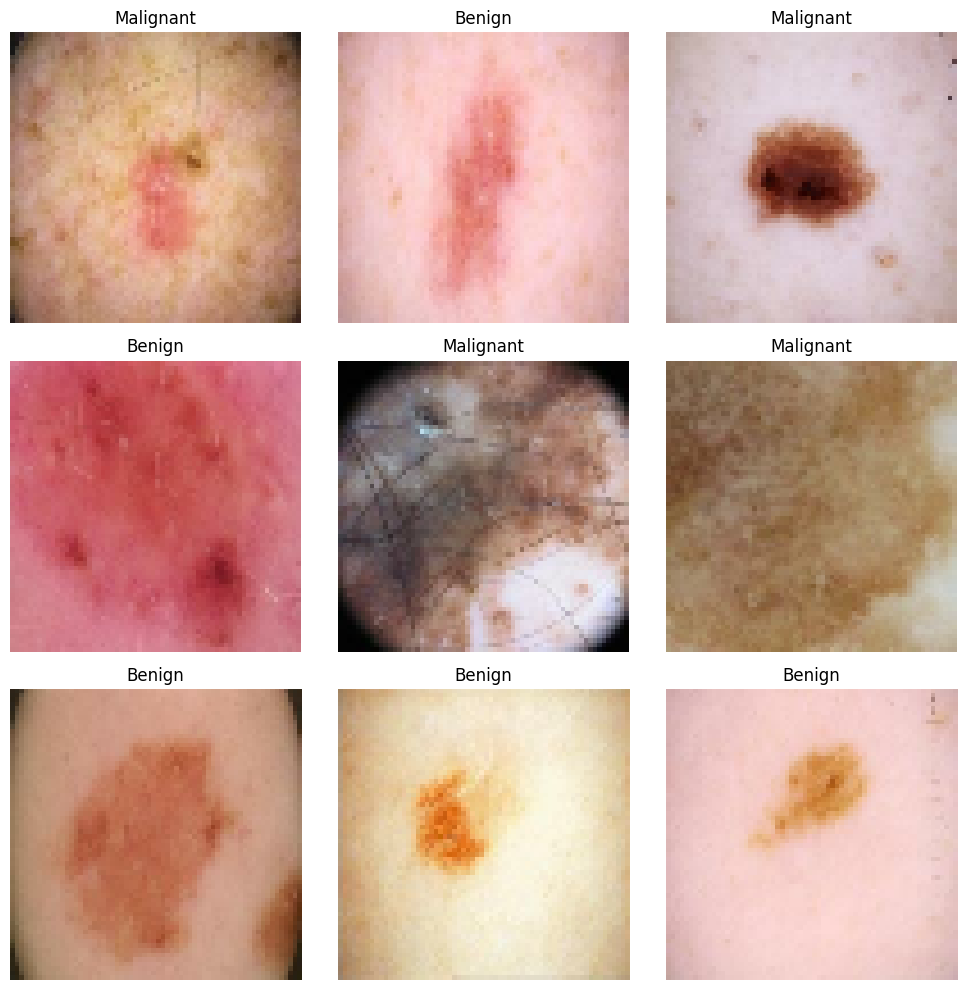

In [9]:
# Display some images from the Training dataset
images, labels = next(iter(train_ds))

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = "Benign" if labels[i].numpy() == 0 else "Malignant"
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Step 7: Data Normalization

In [10]:
def normalize(image, label):
    image = tf.cast(image/255., tf.float32)
    return image, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

* Defines normalize(image, label) to scale pixels from [0,255] to [0,1].

* Applies it to train_ds, val_ds, test_ds so every batch is normalized before training/eval.

* Purpose: stabilize/accelerate training.

# Model Building

#### Step 8: Define the CNN model

In [20]:
# Model Architecture
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation = "relu", input_shape=(64, 64, 3), padding="same", kernel_initializer = "he_normal", kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size = (2, 2), padding="same"))
model.add(Conv2D(64, kernel_size = (3, 3), activation = "relu", padding="same", kernel_initializer = "he_normal", kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size = (2, 2), padding="same"))
model.add(Conv2D(64, kernel_size = (3, 3), activation = "relu", padding="same", kernel_initializer = "he_normal",  kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size = (2, 2), padding="same"))
model.add(Conv2D(32, kernel_size = (3, 3), activation = "relu", padding="same", kernel_initializer = "he_normal", kernel_regularizer = tf.keras.regularizers.l2(0.001)))

model.add(Flatten())

model.add(Dense(units = 128, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(units = 64, activation = "relu", kernel_initializer = "he_normal",  kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(units = 32, activation = "relu",kernel_initializer = "he_normal",  kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(units = 1, kernel_initializer = "glorot_normal", kernel_regularizer = tf.keras.regularizers.l2(0.001), activation = "sigmoid"))

* Input: 64×64×3 RGB.

* Backbone: 4 Conv2D (32→64→64→32, 3×3, ReLU, same padding, He init, L2=1e-3), each of the first three followed by MaxPooling (2×2) → spatial downsample 64→32→16→8.

* Flatten to 2048 features.

* Head: Dense 128 → 64 → 32, each ReLU with Dropout(0.3) and L2.

* Output: Dense 1, sigmoid (binary probability), Glorot init.

* Purpose: CNN classifier for malignant vs benign with strong regularization (L2 + dropout)

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 347,425 (1.33 MB)

 Trainable params: 347,425 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

#### Step 9: Compile the Model

In [22]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

* optimizer="adam" — uses Adam (adaptive moment estimation) to update weights. Defaults: learning rate ≈ 1e-3. Good general-purpose optimizer.

* loss="binary_crossentropy" — appropriate for binary targets (0/1) with a sigmoid output. It compares the predicted probability to the true label.

* metrics=["accuracy"] — reports accuracy each epoch on train/val.

#### Step 10: Save the Best Model

In [23]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="classifier.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
    initial_value_threshold=None
)

* Sets up a ModelCheckpoint to save the entire model.

* File: classifier.h5 (HDF5 format).

* When to save: only when validation accuracy improves (save_best_only=True).

* Monitored metric: val_accuracy (higher is better; mode='max').

* Frequency: check/save at end of each epoch (save_freq='epoch').

* Verbosity: prints a message when saving (verbose=1).

* Baseline: no minimum required; initial_value_threshold=None (default).

* Weights vs model: saves full model, not just weights (save_weights_only=False).

# Train the Model

In [24]:
history = model.fit(train_ds, batch_size = 32, epochs = 30, shuffle = True, validation_data = val_ds, callbacks = [modelCheckpoint])

Epoch 1/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6128 - loss: 1.2360
Epoch 1: val_accuracy improved from -inf to 0.60121, saving model to classifier.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6131 - loss: 1.2354 - val_accuracy: 0.6012 - val_loss: 0.9207
Epoch 2/30
276/279 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7840 - loss: 0.7679
Epoch 2: val_accuracy improved from 0.60121 to 0.81846, saving model to classifier.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7843 - loss: 0.7670 - val_accuracy: 0.8185 - val_loss: 0.6154
Epoch 3/30
278/279 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8264 - loss: 0.6157
Epoch 3: val_accuracy improved from 0.81846 to 0.83429, saving model to classifier.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8265 - loss: 0.6154 - val_accuracy: 0.8343 - val_loss: 0.5765
Epoch 4/30
278/279 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8416 - loss: 0.5512
Epoch 4: val_accuracy improved from 0.8342

* Trains the compiled model on train_ds for 30 epochs, validating on val_ds each epoch.

* Uses the ModelCheckpoint callback to save the best model (by val_accuracy) to classifier.h5.

* Returns a History object (history) with training/validation metrics per epoch.

#### Step 11: Load the Model after Training

In [25]:
model = tf.keras.models.load_model("classifier.h5")

# Evaluation and Metrics

In [65]:
loss, accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test loss: {loss:.4f} | Test accuracy: {accuracy*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9198 - loss: 0.2858
Test loss: 0.3095 | Test accuracy: 91.35%


* Test accuracy = 91.35% → about 9 out of 10 test images were correctly classified at the default 0.5 threshold.

* Test loss (binary cross-entropy) = 0.3095 → the model’s predicted probabilities are reasonably confident overall; lower is better, and ~0.31 is consistent with a ~91% accurate sigmoid classifier.

#### Step 12: Plot Training & Validation Curves

In [60]:
def plot_metrics(train, val, xlabel, ylabel, title, color, window=7, poly=3):
    # Apply Savitzky–Golay filter for smooth trend
    train_smooth = savgol_filter(train, window_length=window, polyorder=poly)
    val_smooth   = savgol_filter(val, window_length=window, polyorder=poly)

    epochs = np.arange(1, len(train) + 1)

    plt.plot(epochs, train_smooth, label="train", c=color[0], marker = "o")
    plt.plot(epochs, val_smooth,   label="validation", c=color[1], marker = "o")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


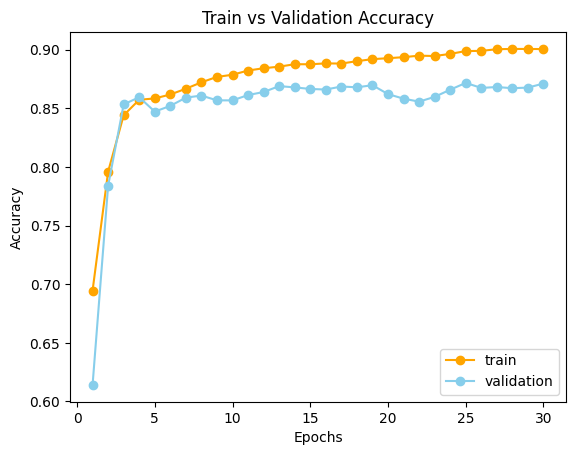

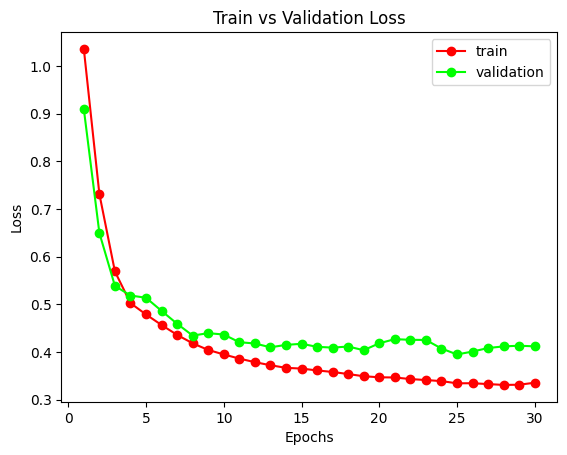

In [61]:
plot_metrics(history.history["accuracy"], history.history["val_accuracy"], "Epochs" , "Accuracy", "Train vs Validation Accuracy", color = ["orange", "skyblue"])
plot_metrics(history.history["loss"], history.history["val_loss"], "Epochs" , "Loss", "Train vs Validation Loss", ["red", "lime"])

**1. Train vs Validation Accuracy (orange = train, blue = val)**

* **Training accuracy increases steadily and reaches ~90%** by the end of training.

* **Validation accuracy improves rapidly in the first few epochs, then flattens around 87%,** showing small fluctuations.

* The gap between training and validation accuracy suggests **the model generalizes fairly, but training accuracy being slightly higher indicates mild overfitting.**

  
**2. Train vs Validation Loss (red = train, green = val)**
* **Training loss decreases smoothly** throughout training, **reaching ~0.33**.

* **Validation loss drops sharply early, then flattens around 0.40–0.42** with small oscillations.

* **The validation loss not decreasing further while training loss continues to drop indicates the model is** starting to fit the training data more than the validation data, a sign **of mild overfitting**.

#### Step 13: ROC-AUC and PR-AUC Curves

In [66]:
def y_true_and_prob(ds, model):
    """Collect ground-truth labels and predicted probabilities from a tf.data.Dataset."""
    # IMPORTANT: ds must NOT be shuffled here
    y_true = np.concatenate([y.numpy().ravel() for _, y in ds], axis=0)
    y_prob = model.predict(ds, verbose=0).ravel()
    return y_true, y_prob
    
def plot_roc_pr(y_true, y_prob, title_suffix="Validation"):
    """Plot ROC and PR curves and print AUCs."""
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({title_suffix})")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    plt.figure(figsize=(5,5))
    plt.plot(recall, precision, label=f"PR AUC (AP) = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve ({title_suffix})")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

    print(f"{title_suffix} — ROC-AUC: {roc_auc:.4f} | PR-AUC (Average Precision): {ap:.4f}")
    return roc_auc, ap


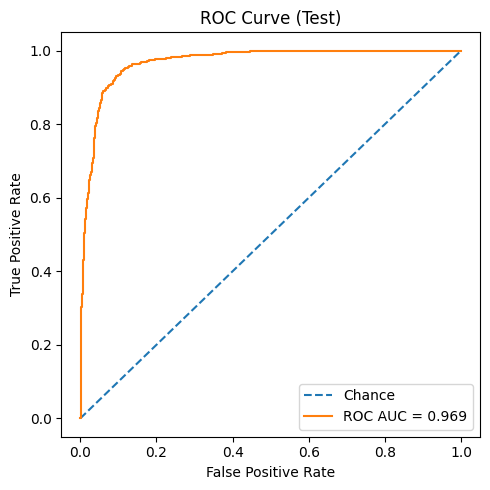

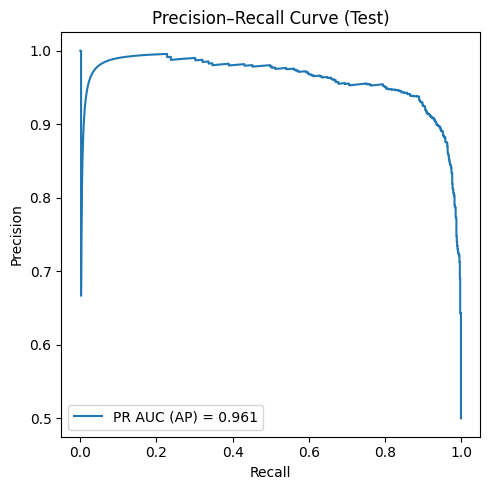

Test — ROC-AUC: 0.9688 | PR-AUC (Average Precision): 0.9608


(0.968801, 0.9607613495097194)

In [67]:
# Test
y_test_true, y_test_prob = y_true_and_prob(test_ds, model)

# ROC: TPR (Sensitivity) vs FPR (Specificity) & PR Curve
plot_roc_pr(y_test_true, y_test_prob, "Test")

**1. ROC Curve**
* **AUC = 0.969** means **the model can separate positive and negative classes with high accuracy**.
* **The curve is far above the diagonal** “chance” line, **indicating much better than random guessing**.
* **High TPR (recall) with low FPR**.

**2. Precision–Recall Curve**
* **PR AUC = 0.961** indicates **excellent performance**.
* Precision remains very high (near 1) until recall is also very high, indicating **the model rarely produces false positives while still detecting most positives.**

Test results show that the model generalizes very well to unseen data, with both ROC-AUC and PR-AUC close to 1. This suggests **high accuracy, low false positives, and low false negatives**.

# Prediction

In [31]:
y_pred_probs = model.predict(test_ds) 
y_pred = (y_pred_probs > 0.5).astype(int) 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Converts the model’s probability outputs into binary class labels (0 or 1) by applying a 0.5 threshold and then casting the result to integers for evaluation.

In [32]:
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())

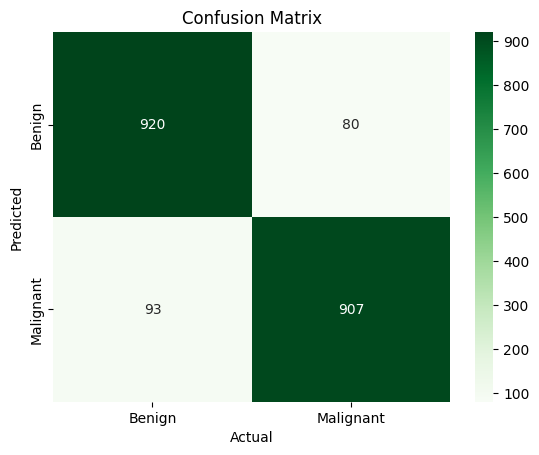

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap = "Greens", annot = True, fmt="d", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

**Confusion matrix** shows the model’s classification performance on the test set for benign and malignant cases:

* True Negatives (Benign correctly predicted as Benign): 920
* False Positives (Benign predicted as Malignant): 80
* False Negatives (Malignant predicted as Benign): 93
* True Positives (Malignant correctly predicted as Malignant): 907

**Interpretation**

* Overall accuracy is high, most predictions are correct.
* Recall for Malignant (how many malignant cases are correctly identified) ≈90.7% → means ~9% of malignant cases are missed.
* Precision for Malignant (how many predicted malignant cases are actually malignant) ≈91.9% → low number of benign cases wrongly labeled malignant.
* Balanced performance between classes, but in a medical context, false negatives (93) are more concerning because missing a malignant case can delay treatment.

In [33]:
# Classification Report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1000
           1       0.92      0.91      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



**Classification Report**
* **Class 0 (Benign)**
    - Precision = 0.91 → When the model predicts "Benign," it's correct 91% of the time.
    
    - Recall = 0.92 → The model correctly identifies 92% of all actual "Benign" cases.
    
    - F1-score = 0.91 → Balanced measure of precision and recall.

* **Class 1 (Malignant)**

    - Precision = 0.92 → When the model predicts "Malignant," it's correct 92% of the time.
    
    - Recall = 0.91 → The model correctly detects 91% of all actual "Malignant" cases.
    
    - F1-score = 0.91 → Good balance between precision and recall.

* **Overall performance**

    - Accuracy = 0.91 → The model correctly classified 91% of all test samples.
    
    - Macro avg = 0.91 → Average performance across both classes, treating them equally.
    
    - Weighted avg = 0.91 → Average performance weighted by the number of samples in each class.
 
**The model is performing very well and balanced across both classes, with no major bias toward either.**

#### Step 14: Visualizing Predictions

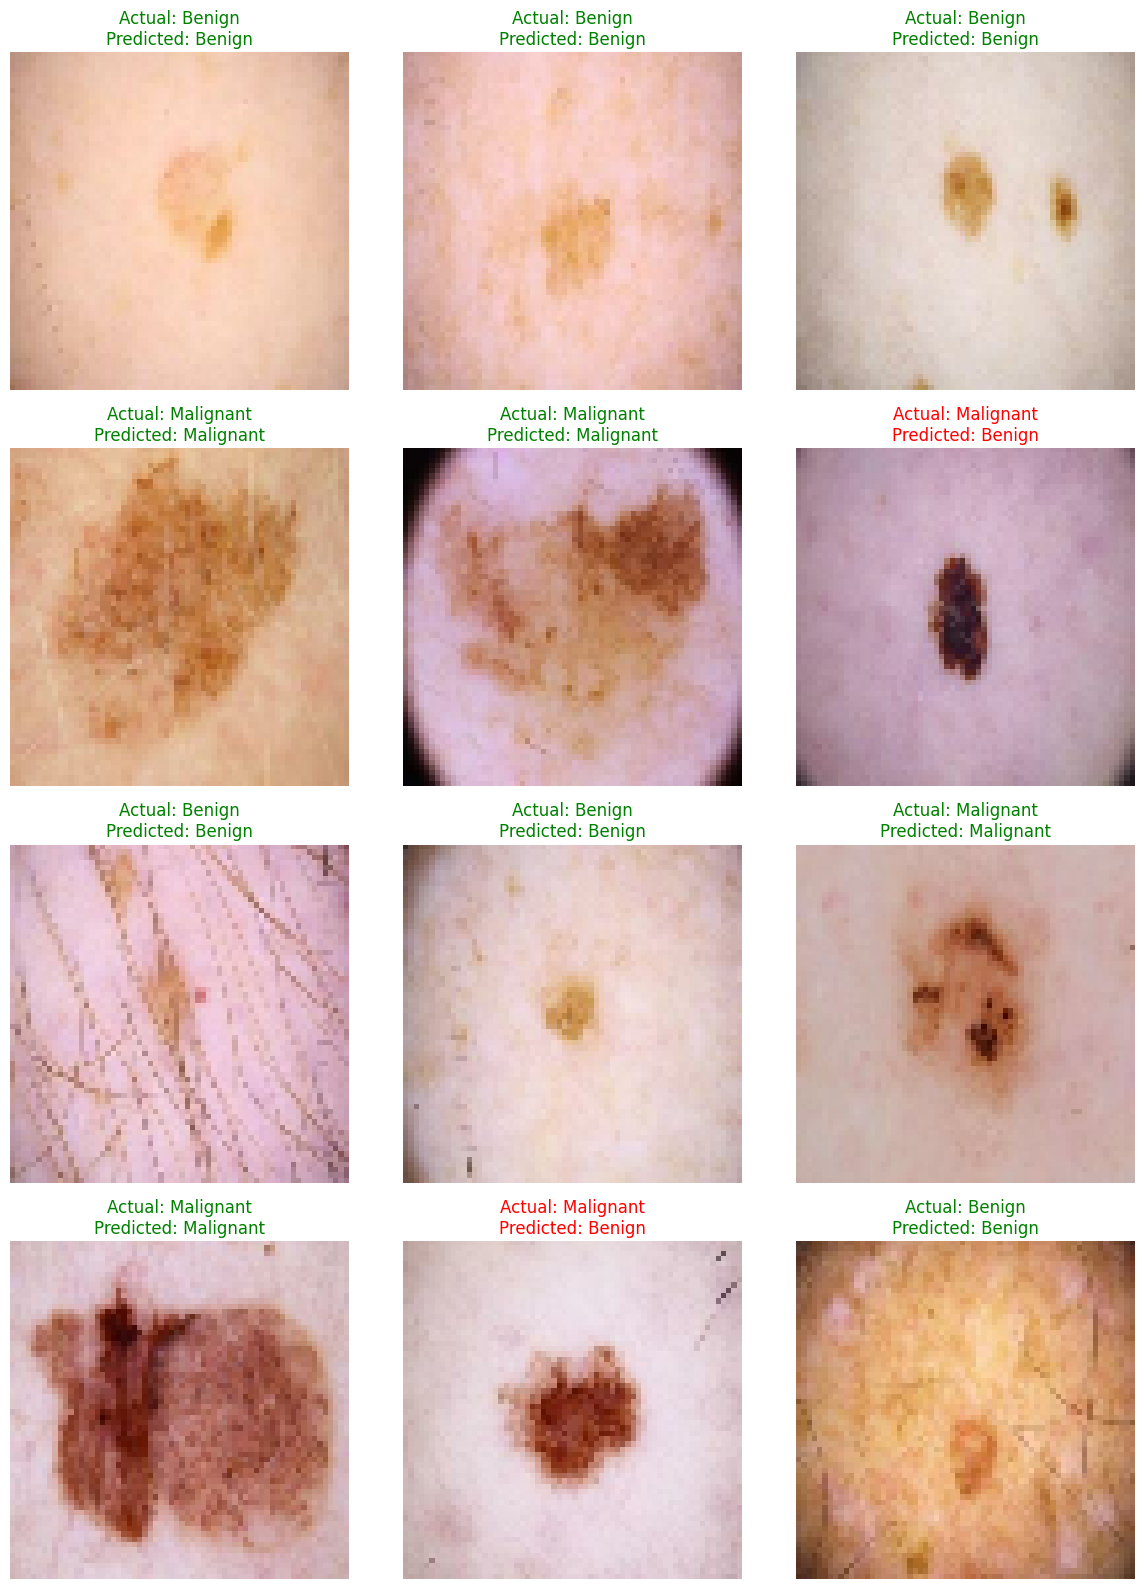

In [36]:
def sample_from_test(test_ds, n_benign=6, n_malignant=6, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)

    benign_imgs, malignant_imgs = [], []

    for img, lab in test_ds.unbatch():
        if int(lab.numpy()) == 0:
            benign_imgs.append(img)
        else:
            malignant_imgs.append(img)

    if len(benign_imgs) == 0 or len(malignant_imgs) == 0:
        raise ValueError("test_ds must contain both classes 0 (benign) and 1 (malignant).")

    random.shuffle(benign_imgs)
    random.shuffle(malignant_imgs)

    b_take = min(n_benign, len(benign_imgs))
    m_take = min(n_malignant, len(malignant_imgs))

    selected_imgs = benign_imgs[:b_take] + malignant_imgs[:m_take]
    selected_labels = [0]*b_take + [1]*m_take

    # Shuffle mix
    combined = list(zip(selected_imgs, selected_labels))
    random.shuffle(combined)
    selected_imgs, selected_labels = zip(*combined)

    images = tf.stack(selected_imgs)
    labels = tf.convert_to_tensor(selected_labels, dtype=tf.int32)
    return images, labels

# ---- choose how many of each to show ----
images, labels = sample_from_test(test_ds, n_benign=6, n_malignant=6, seed=None)

images_np = images.numpy()          # floats in [0,1] are fine for plt.imshow
labels_np = labels.numpy()

# Predict
pred_probs = model.predict(images, verbose=0)
pred_classes = (pred_probs > 0.5).astype("int")

# Plot
n = images_np.shape[0]
cols = 3
rows = int(np.ceil(n / cols))
plt.figure(figsize=(12, 4 * rows))

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images_np[i])
    true_label = "Benign" if labels_np[i] == 0 else "Malignant"
    pred_label = "Benign" if pred_classes[i][0] == 0 else "Malignant"
    title_color = "green" if true_label == pred_label else "red"
    plt.title(f"Actual: {true_label}\nPredicted: {pred_label}", color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Conclusion
The CNN model performs strongly, achieving **\~91% test accuracy**, **ROC-AUC \~0.97**, and **PR-AUC \~0.96**, with balanced precision and recall. It generalizes well, makes mostly correct predictions, and only rarely misclassifies, but could benefit from further tuning and more diverse data.


## Future Scope

* **If overfitting is detected**:
  * Apply stronger **regularization** (Dropout, L2 weight decay).
  * **Data augmentation** and inclusion of more diverse skin lesion images to improve generalization.
  * Use **early stopping** to halt training when validation performance stops improving.
* **Threshold optimization** to reduce false negatives in malignant cases.
* **Model architecture tuning** (e.g., deeper CNN, transfer learning with pre-trained networks like EfficientNet or ResNet) for higher accuracy.
* **Cross-dataset validation** using other publicly available melanoma datasets to test robustness.
* **Deployment as a web or mobile application** for real-time melanoma screening support.